# NebulaNoteHarvester
Automated tool for extracting, processing, and organizing data, images, and metadata from Google Colab notebooks with seamless Drive integration.
This description captures the key aspects:

Automation ("Automated tool")

Core functions ("extracting, processing, and organizing")

Main data types handled ("data, images, and metadata")

Specific platform ("Google Colab notebooks")

Integration feature ("seamless Drive integration")

In [ ]:
import os
import json
import pandas as pd
import base64
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.colab import auth
from googleapiclient.http import MediaFileUpload
import re

# Provided Colab link
colab_link = """
https://colab.research.google.com/drive/<File-ID>-J?usp=sharing

"""

image_folder_id = ""
data_folder_id = ""
metadata_folder_id = ""
drive_folder_id = ""

# Extract the notebook ID from the link
colab_id = colab_link.split('/drive/')[1].split('?')[0]

# Authenticate and initialize the Google Drive API client
auth.authenticate_user()
service = build('drive', 'v3')

def get_colab_name(file_id):
    """Fetch the name of the Colab notebook."""
    try:
        file_metadata = service.files().get(fileId=file_id, fields='name').execute()
        file_name = file_metadata['name']
        name_without_extension = os.path.splitext(file_name)[0]  # Remove the extension
        return name_without_extension
    except HttpError as error:
        print(f"An error occurred while fetching the file metadata: {error}")
        return None

def download_notebook(file_id):
    """Download the Colab notebook content (in .ipynb format)."""
    try:
        # Check if the notebook file already exists and remove it if it does
        notebook_filename = "notebook.ipynb"
        if os.path.exists(notebook_filename):
            os.remove(notebook_filename)
            print(f"Existing file {notebook_filename} removed.")

        # Proceed with downloading the notebook
        request = service.files().get_media(fileId=file_id)
        # Save the file as a .ipynb file
        file_data = request.execute()
        with open(notebook_filename, "wb") as f:
            f.write(file_data)
        print(f"Notebook downloaded successfully as {notebook_filename}.")
        return notebook_filename
    except HttpError as error:
        print(f"An error occurred while downloading the file: {error}")
        return None

def save_to_drive(file_name, folder_id, mime_type=None):
    """Upload the file to a specified folder in Google Drive and return the viewable link.
    Only checks for existing files in the specified folder, not in trash."""
    try:
        # Check if the file exists in the specified folder only
        query = f"name = '{file_name}' and '{folder_id}' in parents and trashed = false"
        results = service.files().list(q=query, fields="files(id, webViewLink)").execute()
        existing_files = results.get('files', [])

        if mime_type is None:
            # Determine mime type based on file extension
            if file_name.endswith('.json'):
                mime_type = 'application/json'
            elif file_name.endswith('.csv'):
                mime_type = 'text/csv'
            elif file_name.endswith('.png'):
                mime_type = 'image/png'
            elif file_name.endswith('.html'):
                mime_type = 'text/html'
            else:
                mime_type = 'application/octet-stream'

        media = MediaFileUpload(file_name, mimetype=mime_type)

        if existing_files:
            # Update the existing file
            file_id = existing_files[0]['id']
            updated_file = service.files().update(
                fileId=file_id,
                media_body=media,
                fields='id, webViewLink'
            ).execute()
            print(f"File {file_name} updated successfully. File ID: {file_id}")
            return updated_file.get('webViewLink')
        else:
            # Create new file
            file_metadata = {
                'name': file_name,
                'parents': [folder_id]
            }

            uploaded_file = service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id, webViewLink'
            ).execute()

            # Make the file viewable by anyone with the link
            service.permissions().create(
                fileId=uploaded_file['id'],
                body={'type': 'anyone', 'role': 'reader'},
                fields='id'
            ).execute()

            print(f"File {file_name} uploaded successfully. File ID: {uploaded_file['id']}")
            return uploaded_file.get('webViewLink')

    except HttpError as error:
        print(f"An error occurred while uploading the file: {error}")
        return None

# Dictionary to store file links
file_links = {}

def extract_and_save_images(notebook_json, notebook_name, parent_folder_id):
    """Extract and save images from notebook output cells, handling both matplotlib and plotly."""
    try:
        image_found = False
        plotly_found = False
        plotly_fig = None

        # First check if plotly is used in the notebook
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or \
                   re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    plotly_found = True
                    break

        # If plotly is found, look for plotly figure
        if plotly_found:
            for cell in notebook_json.get('cells', []):
                if cell.get('cell_type') == 'code':
                    source = "".join(cell.get('source', []))
                    # Look for fig.show() or fig.write_html()
                    if 'fig.show()' in source or 'fig.write_html' in source:
                        # Execute the cell to get the figure
                        namespace = {}
                        try:
                            # Import required plotly modules
                            exec("import plotly.graph_objects as go\nimport plotly.express as px", namespace)

                            # Try to find the figure object in the namespace
                            for var_name, var_value in namespace.items():
                                if isinstance(var_value, (go.Figure, px.Figure)):
                                    plotly_fig = var_value
                                    break

                            if plotly_fig:
                                # Save as HTML
                                html_filename = f"{notebook_name}.html"
                                plotly_fig.write_html(html_filename)
                                print(f"Plotly figure saved as {html_filename}")

                                # Upload to Image folder
                                link = save_to_drive(html_filename, image_folder_id, 'text/html')
                                image_found = True
                                if link:
                                    file_links['html'] = link
                                break
                        except Exception as e:
                            print(f"Error executing plotly cell: {e}")
                            continue

        # If no plotly figure was found or saved, look for static images
        if not image_found:
            for cell in notebook_json.get('cells', []):
                if cell.get('cell_type') == 'code':
                    for output in cell.get('outputs', []):
                        if 'data' in output and 'image/png' in output['data']:
                            # Decode the base64 image data
                            image_data = base64.b64decode(output['data']['image/png'])

                            # Save the image locally
                            image_filename = f"{notebook_name}.png"
                            with open(image_filename, 'wb') as f:
                                f.write(image_data)
                            print(f"Static image saved as {image_filename}")

                            # Upload the image to Image folder
                            link = save_to_drive(image_filename, image_folder_id, 'image/png')
                            image_found = True
                            if link:
                                file_links['png'] = link
                            break
                    if image_found:
                        break

        if not image_found:
            print("No images or plotly figures found in the notebook outputs.")

    except Exception as e:
        print(f"Error processing images: {e}")

def extract_and_save_data(notebook_json, notebook_name, parent_folder_id):
    """Extract and save data dictionary from the notebook."""
    try:
        data_found = False
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                # Look for dictionary assignments like 'data = {...}'
                if 'data = {' in source or 'data={' in source:
                    # Execute the cell to get the data dictionary
                    namespace = {}
                    try:
                        exec(source, namespace)
                        if 'data' in namespace and isinstance(namespace['data'], dict):
                            print("Found data dictionary in notebook")

                            # Convert to DataFrame and save as CSV
                            df = pd.DataFrame.from_dict(namespace['data'])
                            csv_filename = f"{notebook_name}.csv"

                            # Save locally
                            df.to_csv(csv_filename, index=False)
                            print(f"Data saved locally as {csv_filename}")

                            # Upload to Data folder
                            link = save_to_drive(csv_filename, data_folder_id, 'text/csv')
                            data_found = True
                            if link:
                                file_links['csv'] = link
                            break
                    except Exception as e:
                        print(f"Error executing cell: {e}")
                        continue

        if not data_found:
            print("No data dictionary found in the notebook")

    except Exception as e:
        print(f"Error processing data: {e}")

def get_plot_title(notebook_json):
    """Extract the title of the generated plot from the notebook."""
    try:
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))

                # Case 1: Direct title in update_layout with double quotes
                title_match = re.search(r'update_layout\([^)]*title\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 2: Direct title in update_layout with single quotes
                title_match = re.search(r"update_layout\([^)]*title\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 3: Title in dict format within update_layout with double quotes
                title_match = re.search(r'title\s*=\s*"([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 4: Title in dict format within update_layout with single quotes
                title_match = re.search(r"title\s*=\s*'([^']+)'", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 5: Title in nested dictionary within update_layout with double quotes
                title_match = re.search(r'title_text\s*=\s*"([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 6: Title in nested dictionary within update_layout with single quotes
                title_match = re.search(r"title_text\s*=\s*'([^']+)'", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 7: Title in Figure creation with double quotes
                title_match = re.search(r'go\.Figure\([^)]*title\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 8: Title in Figure creation with single quotes
                title_match = re.search(r"go\.Figure\([^)]*title\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 9: plt.title with double quotes
                title_match = re.search(r'plt\.title\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 10: plt.title with single quotes
                title_match = re.search(r"plt\.title\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 11: plt.suptitle with double quotes
                title_match = re.search(r'plt\.suptitle\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 12: plt.suptitle with single quotes
                title_match = re.search(r"plt\.suptitle\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 13: ax.set_title with double quotes
                title_match = re.search(r'(?:ax|axes)\.set_title\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 14: ax.set_title with single quotes
                title_match = re.search(r"(?:ax|axes)\.set_title\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 15: fig.suptitle with double quotes
                title_match = re.search(r'fig\.suptitle\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 16: fig.suptitle with single quotes
                title_match = re.search(r"fig\.suptitle\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 17: Title in dictionary with double quotes
                title_match = re.search(r'title=dict\(text="([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 18: Title in dictionary with single quotes
                title_match = re.search(r"title=dict\(text='([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 19: Title in multi-line update_layout with double quotes
                title_match = re.search(r'update_layout\([^)]*title\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 20: Title in multi-line update_layout with single quotes
                title_match = re.search(r"update_layout\([^)]*title\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 21: Title within a more complex layout (double quotes)
                title_match = re.search(r'update_layout\([^)]*title\s*=\s*{[^}]*text\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 22: Title within a more complex layout (single quotes)
                title_match = re.search(r"update_layout\([^)]*title\s*=\s*{[^}]*text\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

        return "Untitled Plot"  # Default if no title found
    except Exception as e:
        print(f"Error extracting plot title: {e}")
        return "Untitled Plot"

def check_for_plotly(notebook_json):
    """Check if plotly is imported in the notebook in any form."""
    try:
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                # Look for various plotly import formats
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    return True
        return False
    except Exception as e:
        print(f"Error checking for plotly: {e}")
        return False

def get_additional_files(notebook_json):
    """Extract references to additional files from the notebook."""
    try:
        additional_files = []
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))

                # Look for common file operations and patterns
                # Font files
                font_matches = re.findall(r'[\'\"](.*?\.(?:otf|ttf|woff|woff2))[\'\"]', source)
                additional_files.extend(font_matches)

                # Look for explicit file reads/opens
                file_matches = re.findall(r'open\([\'\"](.*?\.[a-zA-Z0-9]+)[\'\"]', source)
                additional_files.extend(file_matches)

                # Look for common image file types
                image_matches = re.findall(r'[\'\"](.*?\.(?:png|jpg|jpeg|bmp|svg|tiff))[\'\"]', source)
                additional_files.extend(image_matches)

                # Look for pd.read operations
                pd_matches = re.findall(r'pd\.read_[a-z]+\([\'\"](.*?\.[a-zA-Z0-9]+)[\'\"]', source)
                additional_files.extend(pd_matches)

        # Remove duplicates and filter out common Python files
        additional_files = list(set(additional_files))
        additional_files = [f for f in additional_files if not f.endswith('.py')]

        if additional_files:
            # Extract just the filename from the path and add the correct directory prefix
            clean_files = []
            for file in additional_files:
                # Get only the filename without any path
                filename = os.path.basename(file)
                clean_files.append(f"AdditionalFilesDirectory/{filename}")
            # Return the list of files as a single string with files separated by commas
            return [", ".join(clean_files)] if len(clean_files) > 0 else ["NA"]
        return ["NA"]
    except Exception as e:
        print(f"Error detecting additional files: {e}")
        return ["NA"]

def save_metadata(notebook_name, notebook_json, parent_folder_id):
    """Create and save metadata about the processed files."""
    try:
        # Get plot title
        plot_title = get_plot_title(notebook_json)

        # Get additional files
        additional_files_list = get_additional_files(notebook_json)

        #Vector Include
        plotly_found = False
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or \
                  re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source) or \
                  re.search(r'\bimport\s+plotly\.graph_objects\s+as\s+\w+\b', source) or \
                  re.search(r'\bimport\s+plotly\.express\s+as\s+\w+\b', source):
                  plotly_found = True
                  break
        if plotly_found:
            vector = "NA"
        else:
            vector = f"VectorDirectory/{notebook_name}.html"

        # Create metadata dictionary
        metadata = {
            'id': [notebook_name],
            'title': [plot_title],
            'language': ["python"],
            'png': [f"PNGDirectory/{notebook_name}.png"],
            'code': [f"CodeDirectory/{notebook_name}.ipynb"],
            'vector': [vector],
            'additional_files': additional_files_list[0],  # Will be either "NA" or a comma-separated list
            'data': [f"DataDirectory/{notebook_name}.csv"]
        }

        # Create DataFrame and save as CSV
        metadata_df = pd.DataFrame(metadata)
        metadata_df = metadata_df.transpose()
        metadata_file_name = f"{notebook_name}.csv"

        # Save locally first
        metadata_df.to_csv(metadata_file_name, header=False)
        print(f"Metadata file {metadata_file_name} saved locally.")

        # Upload to Metadata folder
        link = save_to_drive(metadata_file_name, metadata_folder_id)
        if link:
            file_links['metadata'] = link
        return link
    except Exception as e:
        print(f"Error saving metadata: {e}")

def analyze_notebook(notebook_file, file_id):
    """Analyze the content of a Jupyter notebook and save data to the same location as the notebook."""
    try:
        # Read the notebook
        with open(notebook_file, "r") as f:
            notebook_json = json.load(f)

        # Get parent folder ID of the Colab file
        file_metadata = service.files().get(fileId=file_id, fields="parents").execute()
        parent_folder_id = file_metadata['parents'][0]

        # Extract and save images
        extract_and_save_images(notebook_json, notebook_name, parent_folder_id)

        # Extract and save data dictionary
        extract_and_save_data(notebook_json, notebook_name, parent_folder_id)

        # Save metadata after processing all files
        save_metadata(notebook_name, notebook_json, parent_folder_id)

        # Print all saved file links
        print("\nGenerated File Links:")
        if os.path.exists(f"{notebook_name}.png"):
            print(f"Image (PNG): {file_links.get('png', 'Not saved')}")
        if os.path.exists(f"{notebook_name}.html"):
            print(f"Interactive Plot: {file_links.get('html', 'Not saved')}")
        if os.path.exists(f"{notebook_name}.csv"):
            print(f"Data (CSV): {file_links.get('csv', 'Not saved')}")
        print(f"Metadata: {file_links.get('metadata', 'Not saved')}")

    except json.JSONDecodeError as e:
        print(f"Error decoding notebook JSON: {e}")
    except Exception as e:
        print(f"An error occurred during notebook analysis: {e}")

# Replace this with the folder ID where you want to save the notebook

# Get the Colab notebook's name using its ID
notebook_name = get_colab_name(colab_id)
if notebook_name:
    print(f"Colab Notebook Name: {notebook_name}")
else:
    print("Failed to fetch the notebook name.")

# Download the notebook content and save as 'notebook.ipynb'
notebook_file = download_notebook(colab_id)

# If we successfully downloaded the notebook, upload it to the specified folder in Google Drive
if notebook_file:
    uploaded_file_id = save_to_drive(notebook_file, drive_folder_id)
    if uploaded_file_id:
        analyze_notebook(notebook_file, colab_id)
else:
    print("Failed to download the notebook.")

Colab Notebook Name: 439544
Existing file notebook.ipynb removed.
Notebook downloaded successfully as notebook.ipynb.
File notebook.ipynb updated successfully. File ID: 1DKP6H8rwaGcXaTmb8T0S8eC7kJZrowZF
Error executing plotly cell: name 'go' is not defined
No images or plotly figures found in the notebook outputs.


Found data dictionary in notebook
Data saved locally as 439544.csv
File 439544.csv updated successfully. File ID: 1IjuZMEGhevWhijfUVF_Y7suCO-3f4lhP
Metadata file 439544.csv saved locally.
File 439544.csv updated successfully. File ID: 1y4Kcxpfu14PySNFWvEGEpmibG7A9PLf7

Generated File Links:
Data (CSV): https://drive.google.com/file/d/1IjuZMEGhevWhijfUVF_Y7suCO-3f4lhP/view?usp=drivesdk
Metadata: https://drive.google.com/file/d/1y4Kcxpfu14PySNFWvEGEpmibG7A9PLf7/view?usp=drivesdk


#Working

Existing file notebook.ipynb removed.
Notebook downloaded successfully as notebook.ipynb.
File 01.png uploaded successfully to image folder.


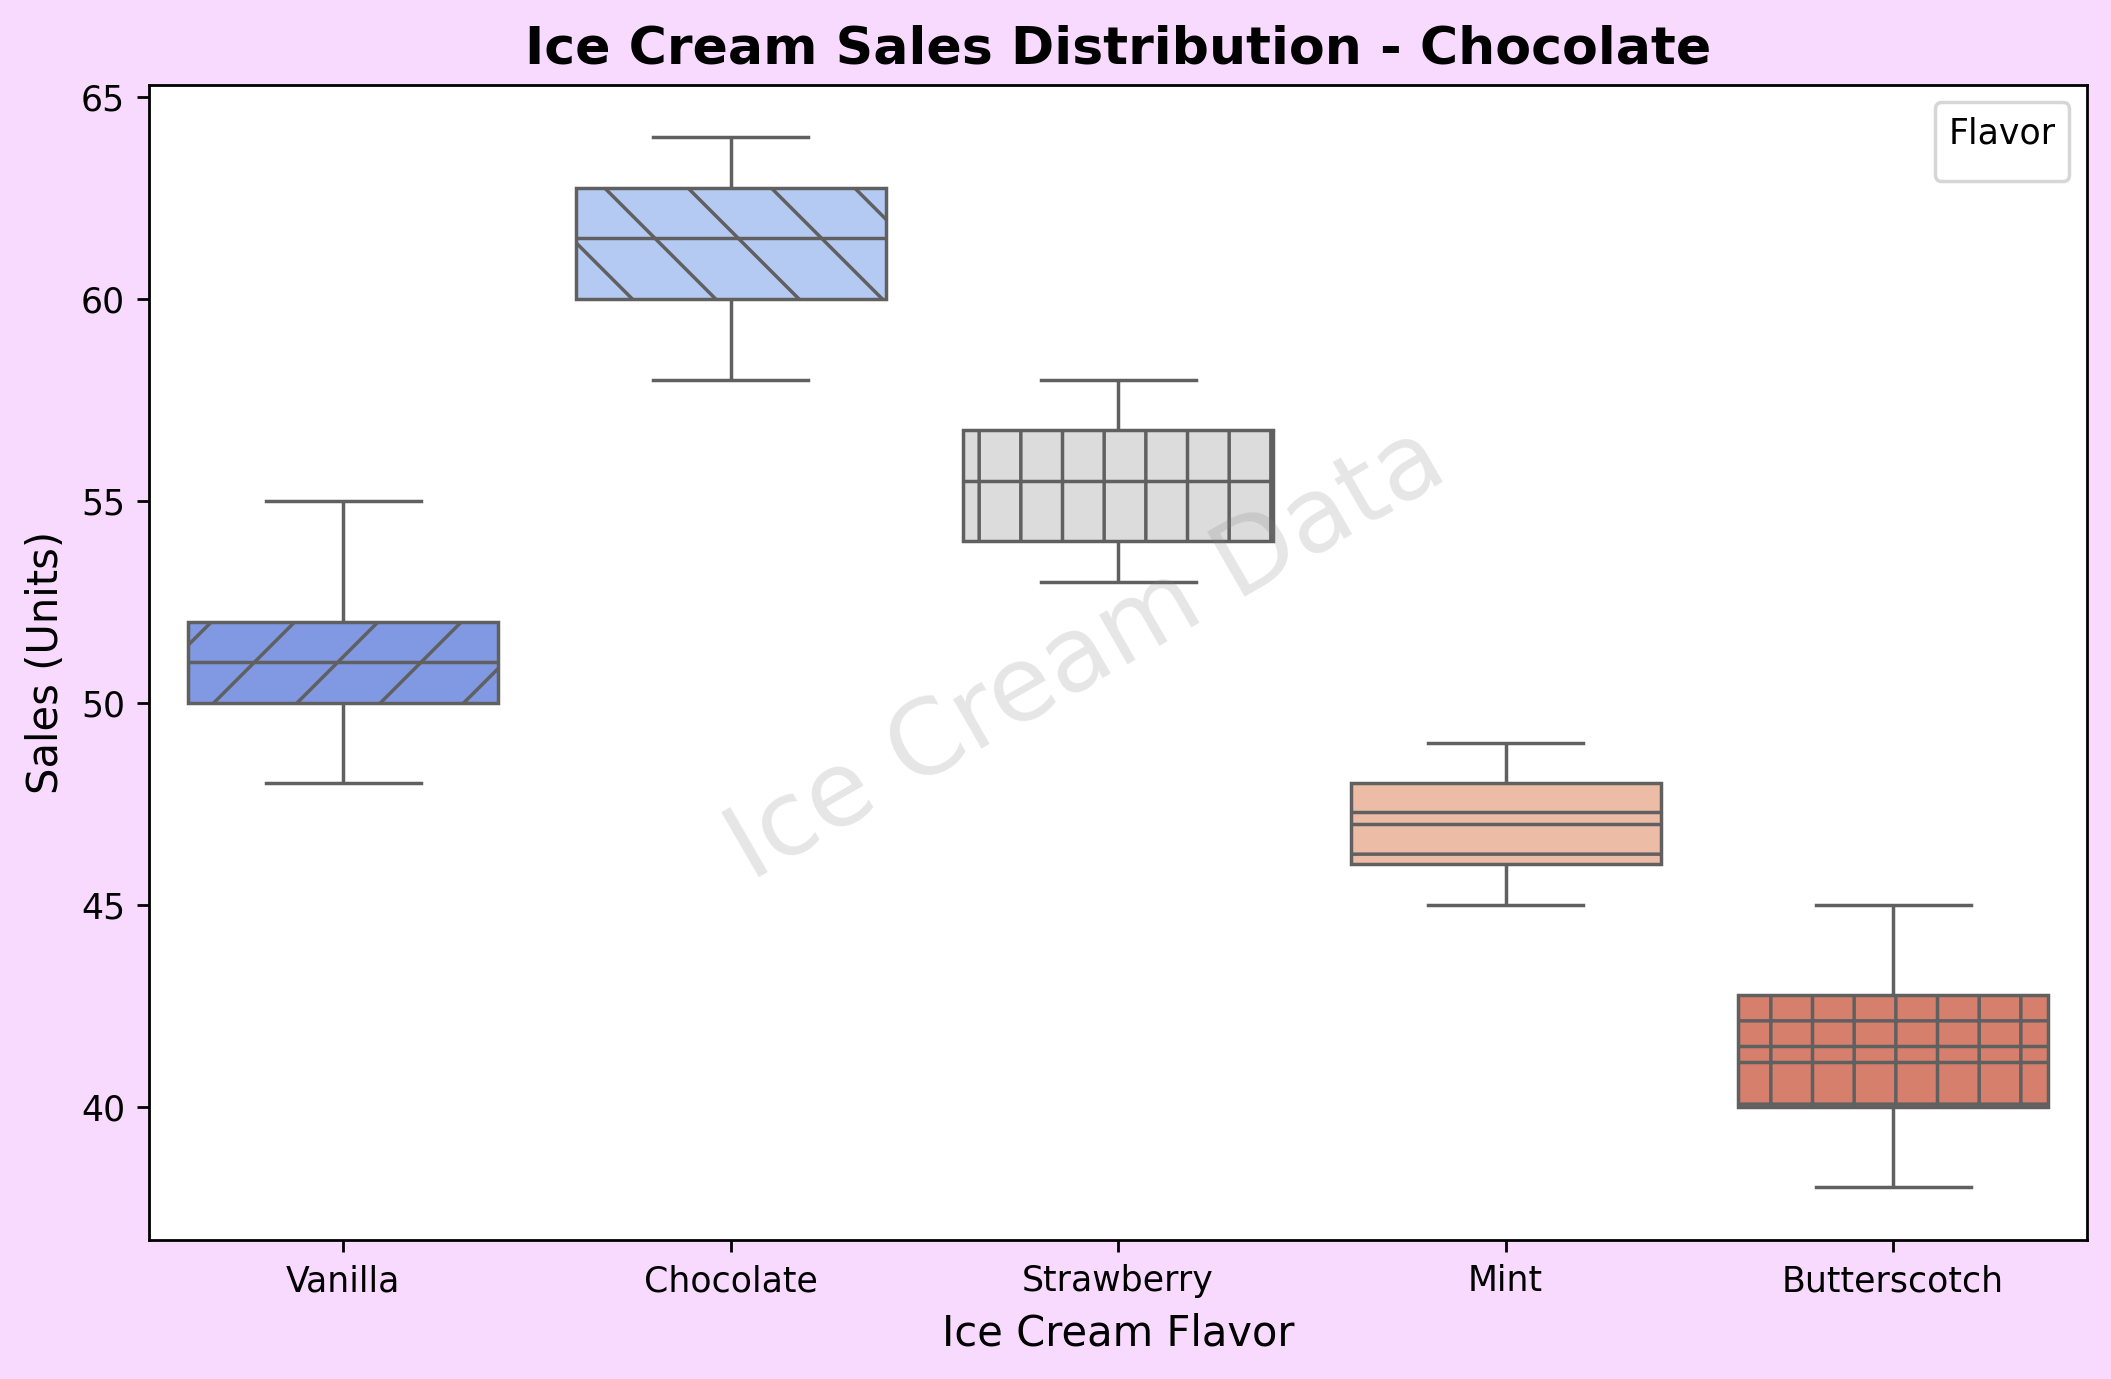

File 01.csv uploaded successfully to data folder.
File 01_metadata.csv uploaded successfully to metadata folder.

Generated File Links:
Image (PNG): https://drive.google.com/file/d/1Mk8sjXhqcbUssHH8a73NrQc6HVyhJtRx/view?usp=drivesdk
Data (CSV): https://drive.google.com/file/d/1Ji_wDgZZHGHDK41P5b0KYtPXq1iSlKZM/view?usp=drivesdk
Metadata: https://drive.google.com/file/d/1zg9K4wDm9LX_e0BzPcKARiN6lDM5zQhh/view?usp=drivesdk


In [ ]:
import os
import json
import pandas as pd  # Ensure pandas is installed
import base64
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.colab import auth
from googleapiclient.http import MediaFileUpload
import re

# Provided Colab link
colab_link = "https://colab.research.google.com/drive/1E1uT2deiqnLIiY6ZnZGhZr9wpJJPupnL?usp=sharing"
image_folder_id = "1xxmcUahwaGCNgfw9KIs3yoPI2wFfZK4e"
data_folder_id = "1VhNsJw9Yn4pjDhiLwyDh4XLZmFNoHEb1"
metadata_folder_id = "1CAr_zw17E1s4nywzRvG9nOSrUQhcNfED"

drive_folder_id = "1-Y9IxWLB8QQgYHex0dZkx0R5oFCx31oE"

# Extract the notebook ID from the link
colab_id = colab_link.split('/drive/')[1].split('?')[0]

# Authenticate and initialize the Google Drive API client
auth.authenticate_user()
service = build('drive', 'v3')

def get_colab_name(file_id):
    """Fetch the name of the Colab notebook."""
    try:
        file_metadata = service.files().get(fileId=file_id, fields='name').execute()
        file_name = file_metadata['name']
        name_without_extension = os.path.splitext(file_name)[0]  # Remove the extension
        return name_without_extension
    except HttpError as error:
        print(f"An error occurred while fetching the file metadata: {error}")
        return None

def download_notebook(file_id):
    """Download the Colab notebook content (in .ipynb format)."""
    try:
        # Check if the notebook file already exists and remove it if it does
        notebook_filename = "notebook.ipynb"
        if os.path.exists(notebook_filename):
            os.remove(notebook_filename)
            print(f"Existing file {notebook_filename} removed.")

        # Proceed with downloading the notebook
        request = service.files().get_media(fileId=file_id)
        # Save the file as a .ipynb file
        file_data = request.execute()
        with open(notebook_filename, "wb") as f:
            f.write(file_data)
        print(f"Notebook downloaded successfully as {notebook_filename}.")
        return notebook_filename
    except HttpError as error:
        print(f"An error occurred while downloading the file: {error}")
        return None

def save_to_drive(file_name, folder_id, mime_type=None):
    """Upload the file to a specified folder in Google Drive and return the viewable link.
    Only checks for existing files in the specified folder, not in trash."""
    try:
        # Check if the file exists in the specified folder only
        query = f"name = '{file_name}' and '{folder_id}' in parents and trashed = false"
        results = service.files().list(q=query, fields="files(id, webViewLink)").execute()
        existing_files = results.get('files', [])

        if mime_type is None:
            # Determine mime type based on file extension
            if file_name.endswith('.json'):
                mime_type = 'application/json'
            elif file_name.endswith('.csv'):
                mime_type = 'text/csv'
            elif file_name.endswith('.png'):
                mime_type = 'image/png'
            elif file_name.endswith('.html'):
                mime_type = 'text/html'
            else:
                mime_type = 'application/octet-stream'

        media = MediaFileUpload(file_name, mimetype=mime_type)

        if existing_files:
            # Update the existing file
            file_id = existing_files[0]['id']
            updated_file = service.files().update(
                fileId=file_id,
                media_body=media,
                fields='id, webViewLink'
            ).execute()
            print(f"File {file_name} updated successfully. File ID: {file_id}")
            return updated_file.get('webViewLink')
        else:
            # Create new file
            file_metadata = {
                'name': file_name,
                'parents': [folder_id]
            }

            uploaded_file = service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id, webViewLink'
            ).execute()

            # Make the file viewable by anyone with the link
            service.permissions().create(
                fileId=uploaded_file['id'],
                body={'type': 'anyone', 'role': 'reader'},
                fields='id'
            ).execute()

            print(f"File {file_name} uploaded successfully. File ID: {uploaded_file['id']}")
            return uploaded_file.get('webViewLink')

    except HttpError as error:
        print(f"An error occurred while uploading the file: {error}")
        return None

# Dictionary to store file links
file_links = {}

def extract_and_save_images(notebook_json, notebook_name, parent_folder_id):
    """Extract and save images from notebook output cells, handling both matplotlib and plotly."""
    try:
        image_found = False
        plotly_found = False
        plotly_fig = None

        # First check if plotly is used in the notebook
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or \
                   re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    plotly_found = True
                    break

        # If plotly is found, look for plotly figure
        if plotly_found:
            for cell in notebook_json.get('cells', []):
                if cell.get('cell_type') == 'code':
                    source = "".join(cell.get('source', []))
                    # Look for fig.show() or fig.write_html()
                    if 'fig.show()' in source or 'fig.write_html' in source:
                        # Execute the cell to get the figure
                        namespace = {}
                        try:
                            # Import required plotly modules
                            exec("import plotly.graph_objects as go\nimport plotly.express as px", namespace)

                            # Try to find the figure object in the namespace
                            for var_name, var_value in namespace.items():
                                if isinstance(var_value, (go.Figure, px.Figure)):
                                    plotly_fig = var_value
                                    break

                            if plotly_fig:
                                # Save as HTML
                                html_filename = f"{notebook_name}.html"
                                plotly_fig.write_html(html_filename)
                                print(f"Plotly figure saved as {html_filename}")

                                # Upload to Image folder
                                link = save_to_drive(html_filename, image_folder_id, 'text/html')
                                image_found = True
                                if link:
                                    file_links['html'] = link
                                break
                        except Exception as e:
                            print(f"Error executing plotly cell: {e}")
                            continue

        # If no plotly figure was found or saved, look for static images
        if not image_found:
            for cell in notebook_json.get('cells', []):
                if cell.get('cell_type') == 'code':
                    for output in cell.get('outputs', []):
                        if 'data' in output and 'image/png' in output['data']:
                            # Decode the base64 image data
                            image_data = base64.b64decode(output['data']['image/png'])

                            # Save the image locally
                            image_filename = f"{notebook_name}.png"
                            with open(image_filename, 'wb') as f:
                                f.write(image_data)
                            print(f"Static image saved as {image_filename}")

                            # Upload the image to Image folder
                            link = save_to_drive(image_filename, image_folder_id, 'image/png')
                            image_found = True
                            if link:
                                file_links['png'] = link
                            break
                    if image_found:
                        break

        if not image_found:
            print("No images or plotly figures found in the notebook outputs.")

    except Exception as e:
        print(f"Error processing images: {e}")

def extract_and_save_data(notebook_json, notebook_name, parent_folder_id):
    """Extract and save data dictionary from the notebook."""
    try:
        data_found = False
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                # Look for dictionary assignments like 'data = {...}'
                if 'data = {' in source or 'data={' in source:
                    # Execute the cell to get the data dictionary
                    namespace = {}
                    try:
                        exec(source, namespace)
                        if 'data' in namespace and isinstance(namespace['data'], dict):
                            print("Found data dictionary in notebook")

                            # Convert to DataFrame and save as CSV
                            df = pd.DataFrame.from_dict(namespace['data'])
                            csv_filename = f"{notebook_name}.csv"

                            # Save locally
                            df.to_csv(csv_filename, index=False)
                            print(f"Data saved locally as {csv_filename}")

                            # Upload to Data folder
                            link = save_to_drive(csv_filename, data_folder_id, 'text/csv')
                            data_found = True
                            if link:
                                file_links['csv'] = link
                            break
                    except Exception as e:
                        print(f"Error executing cell: {e}")
                        continue

        if not data_found:
            print("No data dictionary found in the notebook")

    except Exception as e:
        print(f"Error processing data: {e}")

def get_plot_title(notebook_json):
    """Extract the title of the generated plot from the notebook."""
    try:
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                # Look for common plot title patterns

                # Case 1: Detect plt.title (for Matplotlib)
                if 'plt.title' in source:
                    import re
                    title_match = re.search(r'plt\.title\([\'\"](.*?)[\'\"]', source)
                    if title_match:
                        return title_match.group(1)

                # Case 2: Detect title passed to go.Figure
                title_match_1 = re.search(r'go\.Figure\(\s*title\s*=\s*[\'\"](.*?)[\'\"]', source)
                if title_match_1:
                    return title_match_1.group(1)

                # Case 3: Detect title passed using fig.update_layout
                title_match2 = re.search(r'fig\.update_layout\(\s*title\s*=\s*[\'\"](.*?)[\'\"]', source)
                if title_match2:
                    return title_match2.group(2)

        return "Untitled Plot"  # Default if no title found
    except Exception as e:
        print(f"Error extracting plot title: {e}")
        return "Untitled Plot"



def check_for_plotly(notebook_json):
    """Check if plotly is imported in the notebook in any form."""
    try:
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                # Look for various plotly import formats
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    return True
        return False
    except Exception as e:
        print(f"Error checking for plotly: {e}")
        return False

def get_additional_files(notebook_json):
    """Extract references to additional files from the notebook."""
    try:
        additional_files = []
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))

                # Look for common file operations and patterns
                # Font files
                font_matches = re.findall(r'[\'\"](.*?\.(?:otf|ttf|woff|woff2))[\'\"]', source)
                additional_files.extend(font_matches)

                # Look for explicit file reads/opens
                file_matches = re.findall(r'open\([\'\"](.*?\.[a-zA-Z0-9]+)[\'\"]', source)
                additional_files.extend(file_matches)

                # Look for common image file types
                image_matches = re.findall(r'[\'\"](.*?\.(?:png|jpg|jpeg|bmp|svg|tiff))[\'\"]', source)
                additional_files.extend(image_matches)

                # Look for pd.read operations
                pd_matches = re.findall(r'pd\.read_[a-z]+\([\'\"](.*?\.[a-zA-Z0-9]+)[\'\"]', source)
                additional_files.extend(pd_matches)

        # Remove duplicates and filter out common Python files
        additional_files = list(set(additional_files))
        additional_files = [f for f in additional_files if not f.endswith('.py')]

        if additional_files:
            # Extract just the filename from the path and add the correct directory prefix
            clean_files = []
            for file in additional_files:
                # Get only the filename without any path
                filename = os.path.basename(file)
                clean_files.append(f"AdditionalFilesDirectory/{filename}")
            # Return the list of files as a single string with files separated by commas
            return [", ".join(clean_files)] if len(clean_files) > 0 else ["NA"]
        return ["NA"]
    except Exception as e:
        print(f"Error detecting additional files: {e}")
        return ["NA"]

def save_metadata(notebook_name, notebook_json, parent_folder_id):
    """Create and save metadata about the processed files."""
    try:
        # Get plot title
        plot_title = get_plot_title(notebook_json)

        # Get additional files
        additional_files_list = get_additional_files(notebook_json)

        #Vector Include
        plotly_found = False
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or \
                   re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    plotly_found = True
                    break
        if plotly_found:
            vector = "NA"
        else:
            vector = f"VectorDirectory/{notebook_name}.html"

        # Create metadata dictionary
        metadata = {
            'id': [notebook_name],
            'title': [plot_title],
            'language': ["python"],
            'png': [f"PNGDirectory/{notebook_name}.png"],
            'code': [f"CodeDirectory/{notebook_name}.ipynb"],
            'vector': [vector],
            'additional_files': additional_files_list[0],  # Will be either "NA" or a comma-separated list
            'data': [f"DataDirectory/{notebook_name}.csv"]
        }

        # Create DataFrame and save as CSV
        metadata_df = pd.DataFrame(metadata)
        metadata_df = metadata_df.transpose()
        metadata_file_name = f"{notebook_name}.csv"

        # Save locally first
        metadata_df.to_csv(metadata_file_name, header=False)
        print(f"Metadata file {metadata_file_name} saved locally.")

        # Upload to Metadata folder
        link = save_to_drive(metadata_file_name, metadata_folder_id)
        if link:
            file_links['metadata'] = link
        return link
    except Exception as e:
        print(f"Error saving metadata: {e}")

def analyze_notebook(notebook_file, file_id):
    """Analyze the content of a Jupyter notebook and save data to the same location as the notebook."""
    try:
        # Read the notebook
        with open(notebook_file, "r") as f:
            notebook_json = json.load(f)

        # Get parent folder ID of the Colab file
        file_metadata = service.files().get(fileId=file_id, fields="parents").execute()
        parent_folder_id = file_metadata['parents'][0]

        # Extract and save images
        extract_and_save_images(notebook_json, notebook_name, parent_folder_id)

        # Extract and save data dictionary
        extract_and_save_data(notebook_json, notebook_name, parent_folder_id)

        # Save metadata after processing all files
        save_metadata(notebook_name, notebook_json, parent_folder_id)

        # Print all saved file links
        print("\nGenerated File Links:")
        if os.path.exists(f"{notebook_name}.png"):
            print(f"Image (PNG): {file_links.get('png', 'Not saved')}")
        if os.path.exists(f"{notebook_name}.html"):
            print(f"Interactive Plot: {file_links.get('html', 'Not saved')}")
        if os.path.exists(f"{notebook_name}.csv"):
            print(f"Data (CSV): {file_links.get('csv', 'Not saved')}")
        print(f"Metadata: {file_links.get('metadata', 'Not saved')}")

    except json.JSONDecodeError as e:
        print(f"Error decoding notebook JSON: {e}")
    except Exception as e:
        print(f"An error occurred during notebook analysis: {e}")


# Replace this with the folder ID where you want to save the notebook

# Get the Colab notebook's name using its ID
notebook_name = get_colab_name(colab_id)
if notebook_name:
    print(f"Colab Notebook Name: {notebook_name}")
else:
    print("Failed to fetch the notebook name.")

# Download the notebook content and save as 'notebook.ipynb'
notebook_file = download_notebook(colab_id)

# If we successfully downloaded the notebook, upload it to the specified folder in Google Drive
if notebook_file:
    uploaded_file_id = save_to_drive(notebook_file, drive_folder_id)
    if uploaded_file_id:
        analyze_notebook(notebook_file, colab_id)
else:
    print("Failed to download the notebook.")

# Beta

In [ ]:
import os
import json
import pandas as pd  # Ensure pandas is installed
import base64
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.colab import auth
from googleapiclient.http import MediaFileUpload
import re

# Provided Colab link
colab_link = "https://colab.research.google.com/drive/1E1uT2deiqnLIiY6ZnZGhZr9wpJJPupnL?usp=sharing"
image_folder_id = "1xxmcUahwaGCNgfw9KIs3yoPI2wFfZK4e"
data_folder_id = "1VhNsJw9Yn4pjDhiLwyDh4XLZmFNoHEb1"
metadata_folder_id = "1CAr_zw17E1s4nywzRvG9nOSrUQhcNfED"
drive_folder_id = "1-Y9IxWLB8QQgYHex0dZkx0R5oFCx31oE"

# Extract the notebook ID from the link
colab_id = colab_link.split('/drive/')[1].split('?')[0]

# Authenticate and initialize the Google Drive API client
auth.authenticate_user()
service = build('drive', 'v3')

def get_colab_name(file_id):
    """Fetch the name of the Colab notebook."""
    try:
        file_metadata = service.files().get(fileId=file_id, fields='name').execute()
        file_name = file_metadata['name']
        name_without_extension = os.path.splitext(file_name)[0]  # Remove the extension
        return name_without_extension
    except HttpError as error:
        print(f"An error occurred while fetching the file metadata: {error}")
        return None

def download_notebook(file_id):
    """Download the Colab notebook content (in .ipynb format)."""
    try:
        # Check if the notebook file already exists and remove it if it does
        notebook_filename = "notebook.ipynb"
        if os.path.exists(notebook_filename):
            os.remove(notebook_filename)
            print(f"Existing file {notebook_filename} removed.")

        # Proceed with downloading the notebook
        request = service.files().get_media(fileId=file_id)
        # Save the file as a .ipynb file
        file_data = request.execute()
        with open(notebook_filename, "wb") as f:
            f.write(file_data)
        print(f"Notebook downloaded successfully as {notebook_filename}.")
        return notebook_filename
    except HttpError as error:
        print(f"An error occurred while downloading the file: {error}")
        return None

def save_to_drive(file_name, folder_id, mime_type=None):
    """Upload the file to a specified folder in Google Drive and return the viewable link.
    Only checks for existing files in the specified folder, not in trash."""
    try:
        # Check if the file exists in the specified folder only
        query = f"name = '{file_name}' and '{folder_id}' in parents and trashed = false"
        results = service.files().list(q=query, fields="files(id, webViewLink)").execute()
        existing_files = results.get('files', [])

        if mime_type is None:
            # Determine mime type based on file extension
            if file_name.endswith('.json'):
                mime_type = 'application/json'
            elif file_name.endswith('.csv'):
                mime_type = 'text/csv'
            elif file_name.endswith('.png'):
                mime_type = 'image/png'
            elif file_name.endswith('.html'):
                mime_type = 'text/html'
            else:
                mime_type = 'application/octet-stream'

        media = MediaFileUpload(file_name, mimetype=mime_type)

        if existing_files:
            # Update the existing file
            file_id = existing_files[0]['id']
            updated_file = service.files().update(
                fileId=file_id,
                media_body=media,
                fields='id, webViewLink'
            ).execute()
            print(f"File {file_name} updated successfully. File ID: {file_id}")
            return updated_file.get('webViewLink')
        else:
            # Create new file
            file_metadata = {
                'name': file_name,
                'parents': [folder_id]
            }

            uploaded_file = service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id, webViewLink'
            ).execute()

            # Make the file viewable by anyone with the link
            service.permissions().create(
                fileId=uploaded_file['id'],
                body={'type': 'anyone', 'role': 'reader'},
                fields='id'
            ).execute()

            print(f"File {file_name} uploaded successfully. File ID: {uploaded_file['id']}")
            return uploaded_file.get('webViewLink')

    except HttpError as error:
        print(f"An error occurred while uploading the file: {error}")
        return None

# Dictionary to store file links
file_links = {}

def extract_and_save_images(notebook_json, notebook_name, parent_folder_id):
    """Extract and save images from notebook output cells, handling both matplotlib and plotly."""
    try:
        image_found = False
        plotly_found = False
        plotly_fig = None

        # First check if plotly is used in the notebook
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or \
                   re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    plotly_found = True
                    break

        # If plotly is found, look for plotly figure
        if plotly_found:
            for cell in notebook_json.get('cells', []):
                if cell.get('cell_type') == 'code':
                    source = "".join(cell.get('source', []))
                    # Look for fig.show() or fig.write_html()
                    if 'fig.show()' in source or 'fig.write_html' in source:
                        # Execute the cell to get the figure
                        namespace = {}
                        try:
                            # Import required plotly modules
                            exec("import plotly.graph_objects as go\nimport plotly.express as px", namespace)

                            # Try to find the figure object in the namespace
                            for var_name, var_value in namespace.items():
                                if isinstance(var_value, (go.Figure, px.Figure)):
                                    plotly_fig = var_value
                                    break

                            if plotly_fig:
                                # Save as HTML
                                html_filename = f"{notebook_name}.html"
                                plotly_fig.write_html(html_filename)
                                print(f"Plotly figure saved as {html_filename}")

                                # Upload to Image folder
                                link = save_to_drive(html_filename, image_folder_id, 'text/html')
                                image_found = True
                                if link:
                                    file_links['html'] = link
                                break
                        except Exception as e:
                            print(f"Error executing plotly cell: {e}")
                            continue

        # If no plotly figure was found or saved, look for static images
        if not image_found:
            for cell in notebook_json.get('cells', []):
                if cell.get('cell_type') == 'code':
                    for output in cell.get('outputs', []):
                        if 'data' in output and 'image/png' in output['data']:
                            # Decode the base64 image data
                            image_data = base64.b64decode(output['data']['image/png'])

                            # Save the image locally
                            image_filename = f"{notebook_name}.png"
                            with open(image_filename, 'wb') as f:
                                f.write(image_data)
                            print(f"Static image saved as {image_filename}")

                            # Upload the image to Image folder
                            link = save_to_drive(image_filename, image_folder_id, 'image/png')
                            image_found = True
                            if link:
                                file_links['png'] = link
                            break
                    if image_found:
                        break

        if not image_found:
            print("No images or plotly figures found in the notebook outputs.")

    except Exception as e:
        print(f"Error processing images: {e}")

def extract_and_save_data(notebook_json, notebook_name, parent_folder_id):
    """Extract and save data dictionary from the notebook."""
    try:
        data_found = False
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                # Look for dictionary assignments like 'data = {...}'
                if 'data = {' in source or 'data={' in source:
                    # Execute the cell to get the data dictionary
                    namespace = {}
                    try:
                        exec(source, namespace)
                        if 'data' in namespace and isinstance(namespace['data'], dict):
                            print("Found data dictionary in notebook")

                            # Convert to DataFrame and save as CSV
                            df = pd.DataFrame.from_dict(namespace['data'])
                            csv_filename = f"{notebook_name}.csv"

                            # Save locally
                            df.to_csv(csv_filename, index=False)
                            print(f"Data saved locally as {csv_filename}")

                            # Upload to Data folder
                            link = save_to_drive(csv_filename, data_folder_id, 'text/csv')
                            data_found = True
                            if link:
                                file_links['csv'] = link
                            break
                    except Exception as e:
                        print(f"Error executing cell: {e}")
                        continue

        if not data_found:
            print("No data dictionary found in the notebook")

    except Exception as e:
        print(f"Error processing data: {e}")

def get_plot_title(notebook_json):
    """Extract the title of the generated plot from the notebook."""
    try:
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))

                # Case 1: Direct title in update_layout with double quotes
                title_match = re.search(r'update_layout\([^)]*title\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 2: Direct title in update_layout with single quotes
                title_match = re.search(r"update_layout\([^)]*title\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 3: Title in dict format within update_layout with double quotes
                title_match = re.search(r'title\s*=\s*"([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 4: Title in dict format within update_layout with single quotes
                title_match = re.search(r"title\s*=\s*'([^']+)'", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 5: Title in nested dictionary within update_layout with double quotes
                title_match = re.search(r'title_text\s*=\s*"([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 6: Title in nested dictionary within update_layout with single quotes
                title_match = re.search(r"title_text\s*=\s*'([^']+)'", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 7: Title in Figure creation with double quotes
                title_match = re.search(r'go\.Figure\([^)]*title\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 8: Title in Figure creation with single quotes
                title_match = re.search(r"go\.Figure\([^)]*title\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 9: plt.title with double quotes
                title_match = re.search(r'plt\.title\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 10: plt.title with single quotes
                title_match = re.search(r"plt\.title\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 11: plt.suptitle with double quotes
                title_match = re.search(r'plt\.suptitle\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 12: plt.suptitle with single quotes
                title_match = re.search(r"plt\.suptitle\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 13: ax.set_title with double quotes
                title_match = re.search(r'(?:ax|axes)\.set_title\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 14: ax.set_title with single quotes
                title_match = re.search(r"(?:ax|axes)\.set_title\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 15: fig.suptitle with double quotes
                title_match = re.search(r'fig\.suptitle\("([^"]+)"', source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 16: fig.suptitle with single quotes
                title_match = re.search(r"fig\.suptitle\('([^']+)'\)", source)
                if title_match:
                    return title_match.group(1).strip()

                # Case 17: Title in dictionary with double quotes
                title_match = re.search(r'title=dict\(text="([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 18: Title in dictionary with single quotes
                title_match = re.search(r"title=dict\(text='([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 19: Title in multi-line update_layout with double quotes
                title_match = re.search(r'update_layout\([^)]*title\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 20: Title in multi-line update_layout with single quotes
                title_match = re.search(r"update_layout\([^)]*title\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 21: Title within a more complex layout (double quotes)
                title_match = re.search(r'update_layout\([^)]*title\s*=\s*{[^}]*text\s*=\s*"([^"]+)"', source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

                # Case 22: Title within a more complex layout (single quotes)
                title_match = re.search(r"update_layout\([^)]*title\s*=\s*{[^}]*text\s*=\s*'([^']+)'", source, re.DOTALL)
                if title_match:
                    return title_match.group(1).strip()

        return "Untitled Plot"  # Default if no title found
    except Exception as e:
        print(f"Error extracting plot title: {e}")
        return "Untitled Plot"

def check_for_plotly(notebook_json):
    """Check if plotly is imported in the notebook in any form."""
    try:
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                # Look for various plotly import formats
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    return True
        return False
    except Exception as e:
        print(f"Error checking for plotly: {e}")
        return False

def get_additional_files(notebook_json):
    """Extract references to additional files from the notebook."""
    try:
        additional_files = []
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))

                # Look for common file operations and patterns
                # Font files
                font_matches = re.findall(r'[\'\"](.*?\.(?:otf|ttf|woff|woff2))[\'\"]', source)
                additional_files.extend(font_matches)

                # Look for explicit file reads/opens
                file_matches = re.findall(r'open\([\'\"](.*?\.[a-zA-Z0-9]+)[\'\"]', source)
                additional_files.extend(file_matches)

                # Look for common image file types
                image_matches = re.findall(r'[\'\"](.*?\.(?:png|jpg|jpeg|bmp|svg|tiff))[\'\"]', source)
                additional_files.extend(image_matches)

                # Look for pd.read operations
                pd_matches = re.findall(r'pd\.read_[a-z]+\([\'\"](.*?\.[a-zA-Z0-9]+)[\'\"]', source)
                additional_files.extend(pd_matches)

        # Remove duplicates and filter out common Python files
        additional_files = list(set(additional_files))
        additional_files = [f for f in additional_files if not f.endswith('.py')]

        if additional_files:
            # Extract just the filename from the path and add the correct directory prefix
            clean_files = []
            for file in additional_files:
                # Get only the filename without any path
                filename = os.path.basename(file)
                clean_files.append(f"AdditionalFilesDirectory/{filename}")
            # Return the list of files as a single string with files separated by commas
            return [", ".join(clean_files)] if len(clean_files) > 0 else ["NA"]
        return ["NA"]
    except Exception as e:
        print(f"Error detecting additional files: {e}")
        return ["NA"]

def save_metadata(notebook_name, notebook_json, parent_folder_id):
    """Create and save metadata about the processed files."""
    try:
        # Get plot title
        plot_title = get_plot_title(notebook_json)

        # Get additional files
        additional_files_list = get_additional_files(notebook_json)

        #Vector Include
        plotly_found = False
        for cell in notebook_json.get('cells', []):
            if cell.get('cell_type') == 'code':
                source = "".join(cell.get('source', []))
                if re.search(r'\bimport\s+plotly(\.\w+)*\s+as\s+\w+\b', source) or \
                   re.search(r'\bfrom\s+plotly(\.\w+)*\s+import\s+\w+', source):
                    plotly_found = True
                    break
        if plotly_found:
            vector = "NA"
        else:
            vector = f"VectorDirectory/{notebook_name}.html"

        # Create metadata dictionary
        metadata = {
            'id': [notebook_name],
            'title': [plot_title],
            'language': ["python"],
            'png': [f"PNGDirectory/{notebook_name}.png"],
            'code': [f"CodeDirectory/{notebook_name}.ipynb"],
            'vector': [vector],
            'additional_files': additional_files_list[0],  # Will be either "NA" or a comma-separated list
            'data': [f"DataDirectory/{notebook_name}.csv"]
        }

        # Create DataFrame and save as CSV
        metadata_df = pd.DataFrame(metadata)
        metadata_df = metadata_df.transpose()
        metadata_file_name = f"{notebook_name}.csv"

        # Save locally first
        metadata_df.to_csv(metadata_file_name, header=False)
        print(f"Metadata file {metadata_file_name} saved locally.")

        # Upload to Metadata folder
        link = save_to_drive(metadata_file_name, metadata_folder_id)
        if link:
            file_links['metadata'] = link
        return link
    except Exception as e:
        print(f"Error saving metadata: {e}")

def analyze_notebook(notebook_file, file_id):
    """Analyze the content of a Jupyter notebook and save data to the same location as the notebook."""
    try:
        # Read the notebook
        with open(notebook_file, "r") as f:
            notebook_json = json.load(f)

        # Get parent folder ID of the Colab file
        file_metadata = service.files().get(fileId=file_id, fields="parents").execute()
        parent_folder_id = file_metadata['parents'][0]

        # Extract and save images
        extract_and_save_images(notebook_json, notebook_name, parent_folder_id)

        # Extract and save data dictionary
        extract_and_save_data(notebook_json, notebook_name, parent_folder_id)

        # Save metadata after processing all files
        save_metadata(notebook_name, notebook_json, parent_folder_id)

        # Print all saved file links
        print("\nGenerated File Links:")
        if os.path.exists(f"{notebook_name}.png"):
            print(f"Image (PNG): {file_links.get('png', 'Not saved')}")
        if os.path.exists(f"{notebook_name}.html"):
            print(f"Interactive Plot: {file_links.get('html', 'Not saved')}")
        if os.path.exists(f"{notebook_name}.csv"):
            print(f"Data (CSV): {file_links.get('csv', 'Not saved')}")
        print(f"Metadata: {file_links.get('metadata', 'Not saved')}")

    except json.JSONDecodeError as e:
        print(f"Error decoding notebook JSON: {e}")
    except Exception as e:
        print(f"An error occurred during notebook analysis: {e}")


# Replace this with the folder ID where you want to save the notebook

# Get the Colab notebook's name using its ID
notebook_name = get_colab_name(colab_id)
if notebook_name:
    print(f"Colab Notebook Name: {notebook_name}")
else:
    print("Failed to fetch the notebook name.")

# Download the notebook content and save as 'notebook.ipynb'
notebook_file = download_notebook(colab_id)

# If we successfully downloaded the notebook, upload it to the specified folder in Google Drive
if notebook_file:
    uploaded_file_id = save_to_drive(notebook_file, drive_folder_id)
    if uploaded_file_id:
        analyze_notebook(notebook_file, colab_id)
else:
    print("Failed to download the notebook.")

Colab Notebook Name: 01
Existing file notebook.ipynb removed.
Notebook downloaded successfully as notebook.ipynb.
File notebook.ipynb updated successfully. File ID: 1DKP6H8rwaGcXaTmb8T0S8eC7kJZrowZF
Error executing plotly cell: name 'go' is not defined
No images or plotly figures found in the notebook outputs.


Found data dictionary in notebook
Data saved locally as 01.csv
File 01.csv updated successfully. File ID: 12iiPwSh2hSg9J9k7sbLA_OX2XwFFkCQY
Metadata file 01.csv saved locally.
File 01.csv updated successfully. File ID: 1ooJ3OUvjxpwzHyWtp9_Pfvvh65v6KDOA

Generated File Links:
Image (PNG): Not saved
Data (CSV): https://drive.google.com/file/d/12iiPwSh2hSg9J9k7sbLA_OX2XwFFkCQY/view?usp=drivesdk
Metadata: https://drive.google.com/file/d/1ooJ3OUvjxpwzHyWtp9_Pfvvh65v6KDOA/view?usp=drivesdk
